<a href="https://colab.research.google.com/github/JoshuaDayalGnanamuthu/ModularNeuralNet/blob/main/ModularNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np

def sigmoid(Z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(Z, -500, 500)))

def sigmoid_derivative(Z):
    """Derivative of sigmoid function"""
    s = sigmoid(Z)
    return s * (1 - s)

def relu(Z):
    """ReLU activation function"""
    return np.maximum(0, Z)

def relu_derivative(Z):
    """Derivative of ReLU function"""
    return np.where(Z > 0, 1, 0)

def tanh(Z):
    """Hyperbolic tangent activation function"""
    return np.tanh(Z)

def tanh_derivative(Z):
    """Derivative of tanh function"""
    return 1 - np.power(np.tanh(Z), 2)

activations = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative)
}

class ModularNeuralNet:
    def __init__(self, input_size, hidden_layers=None, activation='sigmoid', final_activation='sigmoid'):
        """
        Initialize a neural network with customizable architecture.

        Parameters:
        - input_size: Number of input features
        - hidden_layers: List of integers specifying the size of each hidden layer
        - activation: Activation function to use ('sigmoid', 'relu', or 'tanh')
        - final_activation: Activation function for output layer
        """
        self.input_size = input_size

        if not hidden_layers:
            hidden_layers = [8, 4, 1]
        elif not isinstance(hidden_layers[-1], int) or hidden_layers[-1] != 1:
            hidden_layers[-1] = 1

        self.layers = [input_size] + hidden_layers
        self.num_layers = len(self.layers)

        if activation in activations:
            self.activation, self.activation_derivative = activations[activation]
        else:
            raise ValueError(f"Activation function '{activation}' is not supported. Use 'sigmoid', 'relu', or 'tanh'.")

        if final_activation in activations:
            self.final_activation, self.final_activation_derivative = activations[final_activation]
        else:
            raise ValueError(f"Final activation function '{final_activation}' is not supported.")

        self.parameters = self.initialize_parameters()
        self.best_parameters = None


    def initialize_parameters(self):
        """Initialize parameters (Weights/Biases) with He initialization"""
        parameters = {}
        for i in range(1, self.num_layers):
            if self.activation == relu:
                factor = np.sqrt(2/self.layers[i-1])
            else:
                factor = np.sqrt(1/self.layers[i-1])
            parameters[f'W{i}'] = np.random.randn(self.layers[i], self.layers[i-1]) * factor
            parameters[f'b{i}'] = np.zeros((self.layers[i], 1))
        return parameters


    def feed_forward(self, X):
        """
        Forward propagation through the network.

        Parameters:
        - X: Input data of shape (n_features, m_examples) where m is number of examples

        Returns:
        - AL: Output of the last layer
        - caches: Dictionary containing activations and pre-activations for backprop
        """
        caches = {'A0': X}
        A = X

        for i in range(1, self.num_layers):
            previous = A
            W = self.parameters[f'W{i}']
            b = self.parameters[f'b{i}']
            Z = W @ previous + b

            if i == self.num_layers - 1:
                A = self.final_activation(Z)
            else:
                A = self.activation(Z)

            caches[f'A{i}'] = A
            caches[f'Z{i}'] = Z
        return A, caches

    def cost(self, A, Y):
        """
        Compute binary cross-entropy cost.

        Parameters:
        - A: Output of the last layer, shape (1, m)
        - Y: True labels, shape (1, m)

        Returns:
        - cost: Binary cross-entropy cost
        """
        m = Y.shape[1]
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
        cost = -1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
        return np.squeeze(cost)

    def backward_propagation(self, Y, caches):
        """
        Backward propagation to compute gradients.

        Parameters:
        - Y: True labels, shape (1, m)
        - caches: Dictionary containing values from forward prop

        Returns:
        - gradients: Dictionary containing gradients
        """
        m = Y.shape[1]
        gradients = {}

        for i in range(self.num_layers - 1, 0, -1):
            A = caches[f'A{i}']
            previous = caches[f'A{i-1}']
            Z = caches[f'Z{i}']

            if i == (self.num_layers - 1):
                dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
                dZ = dA * self.final_activation_derivative(Z)
            else:
                dZ = dA * self.activation_derivative(Z)

            gradients[f'dW{i}'] = 1/m * (dZ @ previous.T)
            gradients[f'db{i}'] = 1/m * np.sum(dZ, axis=1, keepdims=True)

            if i > 1:
                W = self.parameters[f'W{i}']
                dA = W.T @ dZ

        return gradients

    def refresh_paramters(self, gradients, learning_rate):
        """
        Update parameters using gradient descent.

        Parameters:
        - gradients: Dictionary containing gradients
        - learning_rate: Learning rate for gradient descent
        """
        for i in range(1, self.num_layers):
            self.parameters[f'W{i}'] -= learning_rate * gradients[f'dW{i}']
            self.parameters[f'b{i}'] -= learning_rate * gradients[f'db{i}']


    def train(self, X, Y, epochs=1000, learning_rate=0.01, batch_size=None,
              print_interval=100, learning_rate_decay=0.95, decay_interval=100,
              early_stopping_patience=None, validation_data=None):
        """
        Train the neural network.

        Parameters:
        - X: Input data of shape (n_examples, n_features)
        - Y: True labels of shape (n_examples,) or (n_examples, 1)
        - epochs: Number of training epochs
        - learning_rate: Initial learning rate
        - batch_size: Size of mini-batches (if None, use all data)
        - print_interval: How often to print progress
        - learning_rate_decay: Factor to decay learning rate
        - decay_interval: How often to decay learning rate
        - early_stopping_patience: Stop if no improvement after this many epochs
        - validation_data: Tuple of (X_val, Y_val) for validation

        Returns:
        - history: Dictionary of training metrics
        """
        X = np.array(X)
        Y = np.array(Y)
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)

        X_train = X.T
        Y_train = Y.T

        history = {
            'costs': [],
            'val_costs': [] if validation_data else None,
            'learning_rates': []
        }

        best_val_cost = float('inf')
        patience_counter = 0
        current_learning_rate = learning_rate
        m = X_train.shape[1]

        if validation_data:
            X_val, Y_val = validation_data
            if len(Y_val.shape) == 1:
                Y_val = Y_val.reshape(-1, 1)
            X_val = X_val.T
            Y_val = Y_val.T

        for i in range(epochs):
            if batch_size is None:
                A, caches = self.feed_forward(X_train)
                cost = self.cost(A, Y_train)
                gradients = self.backward_propagation(Y_train, caches)
                self.refresh_paramters(gradients, current_learning_rate)
            else:
                cost = 0
                permutation = np.random.permutation(m)
                X_shuffled = X_train[:, permutation]
                Y_shuffled = Y_train[:, permutation]

                num_batches = int(np.ceil(m / batch_size))

                for j in range(num_batches):
                    start_idx = j * batch_size
                    end_idx = min((j + 1) * batch_size, m)

                    X_batch = X_shuffled[:, start_idx:end_idx]
                    Y_batch = Y_shuffled[:, start_idx:end_idx]

                    A_batch, caches_batch = self.feed_forward(X_batch)
                    batch_cost = self.cost(A_batch, Y_batch)
                    cost += batch_cost * (end_idx - start_idx) / m

                    gradients = self.backward_propagation(Y_batch, caches_batch)
                    self.refresh_parameters(gradients, current_learning_rate)

            history['costs'].append(cost)
            history['learning_rates'].append(current_learning_rate)

            if validation_data:
                A_val, _ = self.feed_forward(X_val)
                val_cost = self.cost(A_val, Y_val)
                history['val_costs'].append(val_cost)

                if early_stopping_patience:
                    if val_cost < best_val_cost:
                        best_val_cost = val_cost
                        patience_counter = 0
                        self.best_parameters = {k: v.copy() for k, v in self.parameters.items()}
                    else:
                        patience_counter += 1
                        if patience_counter > early_stopping_patience:
                            print(f"Early stopping at epoch {i}, no improvement for {early_stopping_patience} epochs")
                            if self.best_parameters:
                                self.parameters = self.best_parameters
                            break

            elif early_stopping_patience:
                if cost < best_val_cost:
                    best_val_cost = cost
                    patience_counter = 0
                    self.best_parameters = {k: v.copy() for k, v in self.parameters.items()}
                else:
                    patience_counter += 1
                    if patience_counter > early_stopping_patience:
                        print(f"Early stopping at epoch {i}, no improvement for {early_stopping_patience} epochs")
                        if self.best_parameters:
                            self.parameters = self.best_parameters
                        break

            if i > 0 and i % decay_interval == 0:
                current_learning_rate *= learning_rate_decay

            if i % print_interval == 0 or i == epochs - 1:
                status = f"Epoch {i}: cost = {cost:.6f}, learning_rate = {current_learning_rate:.6f}"
                if validation_data:
                    status += f", val_cost = {val_cost:.6f}"
                print(status)

        if early_stopping_patience and validation_data and self.best_parameters:
            self.parameters = self.best_parameters

        return history

    def predict(self, X, threshold=0.5):
        """
        Make predictions using the trained model.

        Parameters:
        - X: Input data of shape (n_examples, n_features)
        - threshold: Classification threshold for binary predictions

        Returns:
        - predictions: Binary predictions (0 or 1)
        """
        X = np.array(X)
        if X.shape[0] != self.input_size and X.shape[1] == self.input_size:
            X = X.T

        A, _ = self.feed_forward(X)
        predictions = (A > threshold).astype(int)

        return predictions.T

    def predict_probability(self, X):
        """
        Get probability estimates (useful for ROC curves, etc.)

        Parameters:
        - X: Input data of shape (n_examples, n_features)

        Returns:
        - probabilities: Probability estimates (0-1)
        """
        X = np.array(X)
        if X.shape[0] != self.input_size and X.shape[1] == self.input_size:
            X = X.T

        A, _ = self.feed_forward(X)
        return A.T

    def evaluate(self, X, Y):
        """
        Evaluate model performance.

        Parameters:
        - X: Input data of shape (n_examples, n_features)
        - Y: True labels of shape (n_examples,) or (n_examples, 1)

        Returns:
        - metrics: Dictionary with performance metrics
        """
        X = np.array(X)
        Y = np.array(Y)

        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)

        predictions = self.predict(X)
        probabilities = self.predict_probability(X)
        accuracy = np.mean(predictions == Y)

        true_positives = np.sum((predictions == 1) & (Y == 1))
        false_positives = np.sum((predictions == 1) & (Y == 0))
        false_negatives = np.sum((predictions == 0) & (Y == 1))

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        loss = self.cost(probabilities.T, Y.T)

        metrics = {
            'accuracy': accuracy * 100,
            'precision': precision * 100,
            'recall': recall * 100,
            'f1_score': f1 * 100,
            'loss': loss
        }

        return metrics, predictions

    def save_model(self, filename):
        """Save model parameters to a file"""
        model_data = {
            'input_size': self.input_size,
            'layers': self.layers,
            'parameters': {k: v.tolist() for k, v in self.parameters.items()},
            'activation': next(name for name, (func, _) in activations.items()
                              if func == self.activation),
            'final_activation': next(name for name, (func, _) in activations.items()
                                    if func == self.final_activation)
        }
        np.save(filename, model_data, allow_pickle=True)
        print(f"Model saved to {filename}")

    @classmethod
    def load_model(cls, filename):
        """Load model from a file"""
        model_data = np.load(filename, allow_pickle=True).item()
        model = cls(
            input_size=model_data['input_size'],
            hidden_layers=model_data['layers'][1:],
            activation=model_data['activation'],
            final_activation=model_data['final_activation']
        )
        for key, value in model_data['parameters'].items():
            model.parameters[key] = np.array(value)

        return model

In [40]:
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")
print("Path to dataset files:", path)


df = pd.read_csv(path + "/heart.csv")
print(df.head())

X = df.drop("target", axis=1)
y = df["target"]

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop="first"), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


print("Processed train shape:", X_train_processed.shape)
print("Processed test shape:", X_test_processed.shape)

model = ModularNeuralNet(
        input_size=22,
        hidden_layers=[128, 64, 16, 1],
        activation="relu"
    )


model.train(
    X_train_processed,
    y_train,
    epochs=5000,
    learning_rate=0.01,
    print_interval=100,
    learning_rate_decay=0.9,
    decay_interval=500,
    early_stopping_patience=300
)

Path to dataset files: /kaggle/input/heart-disease-dataset
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
Processed train shape: (820, 22)
Processed test shape: (205, 22)
Epoch 0: cost = 0.906160, learning_rate = 0.010000
Epoch 100: cost = 0.418249, learning_rate = 0.010000
Epoch 200: cost = 0.362618, learning_rate = 0.010000
Epoch 300: cost = 0.327647, learning_rate = 0.010000
Epoch 400: cost = 0.299231, learning_rate = 0.0

{'costs': [np.float64(0.9061597816932926),
  np.float64(0.8734135675786516),
  np.float64(0.8442134207142746),
  np.float64(0.8180770362132209),
  np.float64(0.7951662006966042),
  np.float64(0.7740980874306951),
  np.float64(0.7547594735309443),
  np.float64(0.7369730263143371),
  np.float64(0.7206319472117776),
  np.float64(0.7058831483644963),
  np.float64(0.6922488305294673),
  np.float64(0.6797128290912247),
  np.float64(0.6683094260653507),
  np.float64(0.6577917980242566),
  np.float64(0.6480472595712393),
  np.float64(0.6390286516179183),
  np.float64(0.630676454711513),
  np.float64(0.6227630719566384),
  np.float64(0.6151450413836381),
  np.float64(0.6079662262866435),
  np.float64(0.6010829607639506),
  np.float64(0.5945451056321438),
  np.float64(0.5883068081430508),
  np.float64(0.5823594435670345),
  np.float64(0.5766600038479993),
  np.float64(0.5711997687024586),
  np.float64(0.5660133903550048),
  np.float64(0.5610889919265989),
  np.float64(0.5563761090836588),
  np.f


Test accuracy: 98.05%
Precision: 99.01%
Recall: 97.09%
F1 Score: 98.04%
Loss: 0.1058

Predictions vs Actual:
----------------------
Example 1: Predicted 1, Actual 1
Example 2: Predicted 1, Actual 1
Example 3: Predicted 0, Actual 0
Example 4: Predicted 1, Actual 1
Example 5: Predicted 0, Actual 0
Example 6: Predicted 1, Actual 1
Example 7: Predicted 0, Actual 0
Example 8: Predicted 0, Actual 0
Example 9: Predicted 1, Actual 1
Example 10: Predicted 0, Actual 0
Example 11: Predicted 1, Actual 1
Example 12: Predicted 0, Actual 0
Example 13: Predicted 1, Actual 1
Example 14: Predicted 1, Actual 1
Example 15: Predicted 0, Actual 0
Example 16: Predicted 0, Actual 0
Example 17: Predicted 0, Actual 0
Example 18: Predicted 1, Actual 1
Example 19: Predicted 1, Actual 1
Example 20: Predicted 0, Actual 0
Example 21: Predicted 0, Actual 1
Example 22: Predicted 0, Actual 0
Example 23: Predicted 0, Actual 0
Example 24: Predicted 0, Actual 0
Example 25: Predicted 0, Actual 1
Example 26: Predicted 1, A

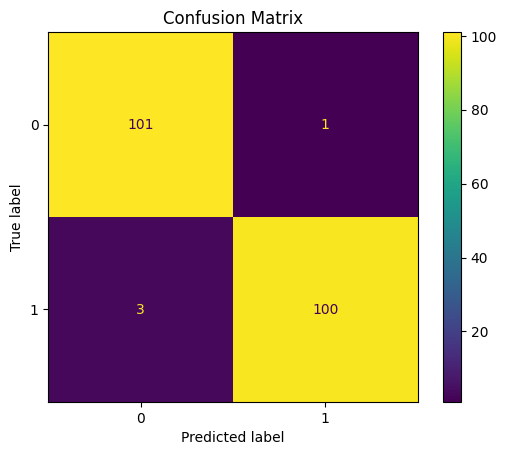

In [42]:
metrics, test_predictions = model.evaluate(X_test_processed, y_test)

print(f"\nTest accuracy: {metrics['accuracy']:.2f}%")
print(f"Precision: {metrics['precision']:.2f}%")
print(f"Recall: {metrics['recall']:.2f}%")
print(f"F1 Score: {metrics['f1_score']:.2f}%")
print(f"Loss: {metrics['loss']:.4f}")

test_predictions = test_predictions.flatten()

print("\nPredictions vs Actual:")
print("----------------------")
for i in range(len(y_test)):
    print(f"Example {i + 1}: Predicted {int(test_predictions[i])}, Actual {int(y_test.iloc[i])}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()



In [25]:
model.save_model('/content/ModularNeuralNet.npy')


Model saved to /content/ModularNeuralNet.npy


In [32]:
loaded_model = ModularNeuralNet.load_model('/content/ModularNeuralNet.npy')

predictions = loaded_model.predict(X_test_processed)
for i in predictions:
  print(i[0])

1
1
0
1
0
1
0
0
1
0
1
0
1
1
0
0
0
1
1
0
0
0
0
0
0
1
1
1
0
0
0
1
0
1
1
1
0
1
1
1
0
0
1
0
0
0
0
0
0
1
1
0
0
0
1
1
0
0
1
1
1
1
0
1
0
0
1
0
0
1
0
0
0
1
1
1
0
0
1
1
0
0
0
0
1
0
1
0
0
0
0
0
1
1
1
1
0
0
0
0
1
0
0
1
0
1
0
1
0
1
1
1
1
0
1
1
0
1
1
0
1
1
0
0
1
0
1
0
0
1
1
0
1
1
0
1
0
1
1
0
1
1
1
1
1
1
1
1
0
0
0
0
1
1
0
0
0
1
0
0
1
1
0
0
1
1
0
0
1
1
0
1
1
0
1
1
1
0
0
1
1
0
1
0
1
1
1
1
1
1
1
1
0
0
0
1
0
0
1
1
1
1
1
0
0
527    1
359    1
447    0
31     1
621    0
      ..
832    1
796    1
644    1
404    0
842    0
Name: target, Length: 205, dtype: int64
